In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import sys
from bs4 import BeautifulSoup as bs

In [42]:
# Path to folder containg supplementary code.
sys.path.insert(1, '../src')

import se_post_processing as sepp
import tokenizers as tkn
import config_reader as cr

# Table of Contents
---

### 1. Introduction
### 2. Data processing
### 3. Modeling
### 4. Conclusion

# 1. Introduction
---

In this notebook, we create a baseline model for predicting whether or not a question on the User Experience Stack Exchange will be answered within 7 days. We first process the text and engineer features from the contents of the post, then we train and evaluate a logistic regression model.

# 2. Data processing
---

We begin by preparing the Stack Exchange post data for modeling. We need to process and tokenize the text in the bodies and titles of the questions and dummify the tag variables. We also need to engineer features from the various HTML tags found in the questions.

In [43]:
# Read data and insepct first five rows.
posts = pd.read_xml(cr.get_path('ux_posts'))
posts.head()

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,...,Tags,AnswerCount,CommentCount,ContentLicense,ParentId,ClosedDate,CommunityOwnedDate,FavoriteCount,OwnerDisplayName,LastEditorDisplayName
0,1,1,13.0,2010-08-09T19:41:42.073,33,7711.0,<p>I've read suggestions that contextual menu ...,17654.0,7627.0,2012-08-24T15:54:51.290,...,<contextual-menu><radial-menu>,10.0,2,CC BY-SA 2.5,NaN,None,None,NaN,None,None
1,2,1,4.0,2010-08-09T19:42:31.400,26,10897.0,<p>When I have to load new information from my...,27.0,31.0,2010-08-09T19:49:55.297,...,<performance><response-time><ajax>,4.0,1,CC BY-SA 2.5,NaN,None,None,NaN,None,None
2,3,2,NaN,2010-08-09T19:45:42.610,33,NaN,<p>I guess this should follow the classic usab...,31.0,NaN,None,...,None,NaN,6,CC BY-SA 2.5,2.0,None,None,NaN,None,None
3,4,2,NaN,2010-08-09T19:45:55.730,16,NaN,<p>I've always been told that a delay of 100ms...,17654.0,-1.0,2020-06-16T10:51:03.917,...,None,NaN,5,CC BY-SA 2.5,2.0,None,None,NaN,None,None
4,5,2,NaN,2010-08-09T19:46:07.133,3,NaN,<p>The information should load as fast as poss...,12.0,NaN,None,...,None,NaN,0,CC BY-SA 2.5,2.0,None,None,NaN,None,None


In [44]:
# Convert `CreationDate` to date time.
posts['CreationDate'] = pd.to_datetime(posts['CreationDate'])

---

We need to separate the question posts from other kinds of posts and create a column which stores our target variable: whether or not a question was answered within 7 days of posting.

In [45]:
# Isolate questions in a separate data frame.
q_sel = posts['PostTypeId'] == 1
questions = posts.loc[q_sel, :]

In [46]:
# Isolate answers in a separate data frame.
a_sel = posts['PostTypeId'] == 2
answers = posts.loc[a_sel, :]

In [47]:
# Dates of first answers.
answer_dates = answers.groupby('ParentId')['CreationDate'].min().rename('AnswerDate')

# Merge first answer dates with questions.
questions = questions.merge(
    answer_dates,
    how='left',
    left_on='Id',
    right_index=True
)

In [48]:
# Question answer time.
answer_time = questions['AnswerDate'] - questions['CreationDate']

# Target column: was the question answered within 7 days?
questions['Answered7d'] = answer_time.dt.days <= 7

---

We wish to engineer several features for our predictive model. We first extract the hour of the day during which a question was posted, since questions posted during odd hours are more liable to be buried.

In [50]:
# Get hour of day from question creation time.
questions['CreationTime'] = questions['CreationDate'].dt.hour

C:\Users\ealwa\AppData\Local\Temp\ipykernel_2908\1566296009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions.loc[:, 'CreationTime'] = questions.loc[:, 'CreationDate'].dt.hour


We engineer a number of features which measure the types of content found in a question, such as the number of lines of text in the post. We also count the number of various HTML tags that appear in questions, including `blockquote`, `ul`, and `img`.

The functions used to extract these features are in the imported Python module `se_post_processing.py`, which can be found in the `src` folder of the project directory.

In [51]:
# Count number of lines of text.
questions['Lines'] = questions['Body'] \
    .apply(sepp.count_lines)

# Count number of table HTML tags.
questions['Tables'] = questions['Body'] \
    .apply(lambda x: sepp.count_html_tags(x, 'table'))

# Count number of quote HTML tags.
questions['Quotes'] = questions['Body'] \
    .apply(lambda x: sepp.count_html_tags(x, 'blockquote'))

# Count number of bullet list HTML tags.
questions['BulletLists'] = questions['Body'] \
    .apply(lambda x: sepp.count_html_tags(x, 'ul'))

# Count number of image HTML tags.
questions['Images'] = questions['Body'] \
    .apply(lambda x: sepp.count_html_tags(x, 'img'))

C:\Users\ealwa\AppData\Local\Temp\ipykernel_2908\2405708073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions.loc[:, 'Lines'] = questions.loc[:, 'Body'] \
C:\Users\ealwa\AppData\Local\Temp\ipykernel_2908\2405708073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  questions.loc[:, 'Tables'] = questions.loc[:, 'Body'] \
C:\Users\ealwa\AppData\Local\Temp\ipykernel_2908\2405708073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

---

The next step is to separate our data into training and test sets. We extract a random sample of $20\%$ of the data for testing.

In [52]:
from sklearn.model_selection import train_test_split

In [53]:
# Columns to be included as features.
feat_cols = [
    'CreationTime',
    'Title',
    'Body',
    'Tags',
    'Lines',
    'Quotes',
    'BulletLists',
    'Tables',
    'Images'
]

# Separate features and target variable.
X = questions.loc[:, feat_cols]
y = questions['Answered7d']

# Split into training and test sets.
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2)

---

We separate the lists of tags in the training questions into binary features representing whether a question contains given tags. We perform this feature engineering after splitting into training and test sets to avoid the possibility of the training data containing zero columns.

In [54]:
# Use regex to extract and explode the lists of tags and get the unique tags.
q_tag_lists = X_train['Tags'].str.findall('<.*?>')
q_tags = q_tag_lists.explode().str.replace('<|>', '', regex=True)
unique_q_tags = q_tags.unique()

In [55]:
# Lists to store tag columns.
train_tag_cols = []
test_tag_cols = []

# Loop through the tags and create corresponding features for training and test data.
for tag in unique_q_tags:
    # Name for the tag column.
    col_name = f'Tag_{tag}'

    # Get questions with the given tag.
    tag_indices = q_tags[q_tags == tag].index

    # Create column in the training set indicating whether a question has the given tag.
    is_tagged_train = X_train.index.isin(tag_indices)
    is_tagged_train = pd.Series(
        data=is_tagged_train,
        index=X_train.index,
        dtype=int,
        name=col_name
    )

    # Create column in the test set indicating whether a question has the given tag.
    is_tagged_test = X_test.index.isin(tag_indices)
    is_tagged_test = pd.Series(
        data=is_tagged_test,
        index=X_test.index,
        dtype=int,
        name=col_name
    )

    train_tag_cols.append(is_tagged_train)
    test_tag_cols.append(is_tagged_test)


# Concatenate the tagg columns into a data frame.
tagged_df_train = pd.concat(train_tag_cols, axis=1)
tagged_df_test = pd.concat(test_tag_cols, axis=1)

# Concatenate the tag data frames with the training and test data frames.
X_train = pd.concat([X_train, tagged_df_train], axis=1).drop('Tags', axis=1)
X_test = pd.concat([X_test, tagged_df_test], axis=1).drop('Tags', axis=1)

---

Before modeling, we need is to tokenize the titles and bodies of questions. We create separate functions for tokenizing question titles and bodies. We only include tokens consisting of alphabetic characters. Wew convert tokens to lemmas and exclude the standard English stop words. We vectorize the question titles and bodies as bags of words with tf-idf normalization. We use a maximum of 1,000 (10,000) features for the titles (bodies).

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [59]:
# Lemmatizer and list of stop words.
lemmatizer = WordNetLemmatizer()
stops = set(stopwords.words('english'))

# Title vectorizer
vectorizer_title = TfidfVectorizer(
    tokenizer=lambda title: tkn.tokenize_title(title, lemmatizer, stops),
    token_pattern=None,
    max_df = 0.7,
    min_df = 0.001,
    max_features=1000
)

# Body vectorizer
vectorizer_post = TfidfVectorizer(
    tokenizer=lambda post: tkn.tokenize_post(post, lemmatizer, stops),
    token_pattern=None,
    max_df = 0.7,
    min_df = 0.001,
    max_features=10000
)

In [60]:
# Create the bags of words.
bag_of_words_title = vectorizer_title.fit(X_train['Title'])
bag_of_words_post = vectorizer_post.fit(X_train['Body'])

In [61]:
# Transform training words into data frames.

X_train_title_words = bag_of_words_title.transform(X_train['Title'])

X_train_title_words = pd.DataFrame(
    data=X_train_title_words.toarray(),
    index=X_train.index,
    columns=bag_of_words_title.get_feature_names_out()
)

X_train_post_words = bag_of_words_post.transform(X_train['Body'])

X_train_post_words = pd.DataFrame(
    data=X_train_post_words.toarray(),
    index=X_train.index,
    columns=bag_of_words_post.get_feature_names_out()
)


In [62]:
# Transform test words into data frames.

X_test_title_words = bag_of_words_title.transform(X_test['Title'])

X_test_title_words = pd.DataFrame(
    data=X_test_title_words.toarray(),
    index=X_test.index,
    columns=bag_of_words_title.get_feature_names_out()
)

X_test_post_words = bag_of_words_post.transform(X_test['Body'])

X_test_post_words = pd.DataFrame(
    data=X_test_post_words.toarray(),
    index=X_test.index,
    columns=bag_of_words_post.get_feature_names_out()
)

In [63]:
# Merge vectorized words into training set.
X_train = pd.concat(
    [X_train, X_train_title_words, X_train_post_words],
    axis=1
).drop(['Title', 'Body'], axis=1)

# Free memory.
del X_train_title_words
del X_train_post_words

In [64]:
# Merge vectorized words into test set.
X_test = pd.concat(
    [X_test, X_test_title_words, X_test_post_words],
    axis=1
).drop(['Title', 'Body'], axis=1)

# Free memory.
del X_test_title_words
del X_test_post_words

# 3. Modeling
---

With our data processing complete, we move on to modeling. We use a logistic regression model to predict whether or not a question is answered within 7 days. Our main reason for choosing logistic regression is computational efficiency (we have a large number of features) and interpretability. We would like to draw inferences from our model about how Stack Exchange users can structure their questions to maximize the odds of getting a timely answer.

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [66]:
# Fit logistic regression model.
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

---

We investigate the 20 features which have the largest positive (negative) coefficient in our logistic regression model.

In [67]:
# Get coefficients with feature names.
coefs = pd.Series(
    data=lr.coef_[0],
    index=X_train.columns
).sort_values(ascending=False)

Text(0, 0.5, 'Coefficient')

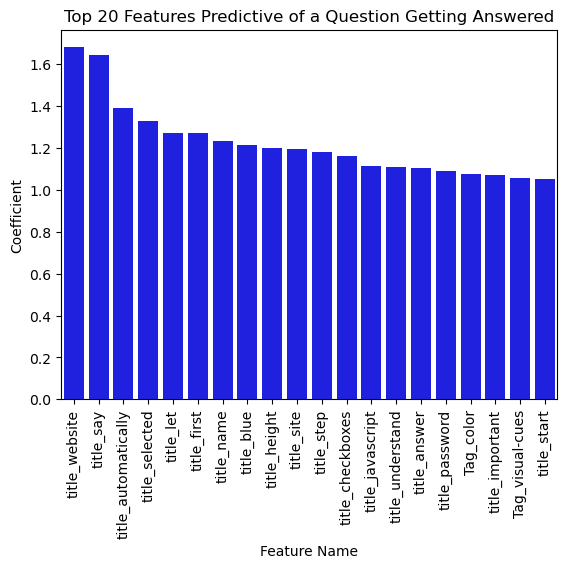

In [68]:
# Get top 20 positive coefficients.
pos_coefs = coefs[coefs > 0].sort_values(ascending=False)[:20]

# Plot top 20 positive coefficients.
ax = sns.barplot(
    x=pos_coefs.index,
    y=pos_coefs.values,
    color='blue'
)
ax.set_title('Top 20 Features Predictive of a Question Getting Answered')
ax.set_xlabel('Feature Name')
ax.set_xticks(range(20), labels=pos_coefs.index, rotation=90)
ax.set_ylabel('Coefficient')

We see the top 20 features with positive coefficients are all related to question tags or titles. The popularity of Javascript may account for the `title_javascript` feature's appearance. Some features, such as `title_let` and `post_say` seem highly suspect and indicative of flaws in our tokenizers.

Text(0, 0.5, 'Coefficient')

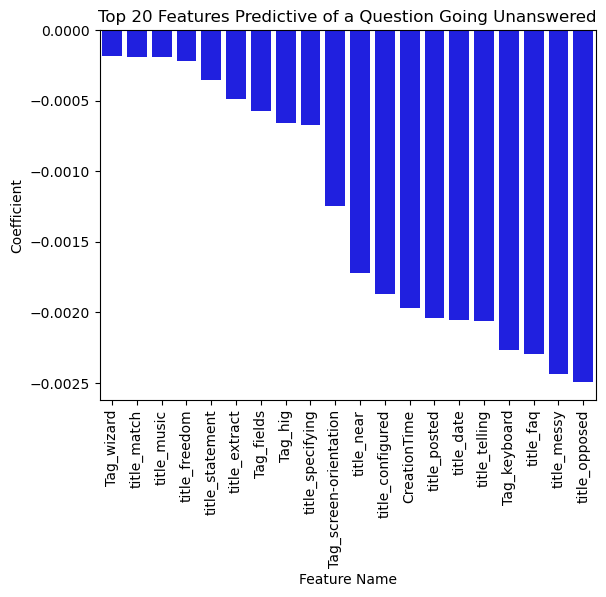

In [69]:
# Get top 20 negative coefficients.
neg_coefs = coefs[coefs < 0].sort_values(ascending=False)[:20]

# Plot top 20 negative coefficients.
ax = sns.barplot(
    x=neg_coefs.index,
    y=neg_coefs.values,
    color='blue'
)
ax.set_title('Top 20 Features Predictive of a Question Going Unanswered')
ax.set_xlabel('Feature Name')
ax.set_xticks(range(20), labels=neg_coefs.index, rotation=90)
ax.set_ylabel('Coefficient')

We see the top 20 features with negative coefficients are also all related to question titles or tags, except for `CreationTime`. The presence of `CreationTime` suggests that questions posted later in the day are less likely to be answered. Again, many of the features seem to indicate flaws in our tokenizers.

In [70]:
# Training set class balance
y_train.value_counts(normalize=True).round(2)

Answered7d
1    0.94
0    0.06
Name: proportion, dtype: float64

In [71]:
# Test set class balance
y_test.value_counts(normalize=True).round(2)

Answered7d
1    0.94
0    0.06
Name: proportion, dtype: float64

In [72]:
# Model predictions.
train_predict = lr.predict_proba(X_train)[:, 1] >= 0.9
test_predict = lr.predict_proba(X_test)[:, 1] >= 0.9

# Test classification report.
train_cr = classification_report(y_train, train_predict)

# Test classification report.
test_cr = classification_report(y_test, test_predict)

# Print classification reports.
print('Train:')
print(train_cr)
print()
print('Test:')
print(test_cr)

Train:
              precision    recall  f1-score   support

           0       0.27      0.72      0.39      1605
           1       0.98      0.87      0.92     24569

    accuracy                           0.86     26174
   macro avg       0.63      0.80      0.66     26174
weighted avg       0.94      0.86      0.89     26174


Test:
              precision    recall  f1-score   support

           0       0.07      0.15      0.10       371
           1       0.95      0.89      0.91      6173

    accuracy                           0.84      6544
   macro avg       0.51      0.52      0.51      6544
weighted avg       0.90      0.84      0.87      6544



By setting a high probability threshold, we obtained decent recall on the `0` class while still maintaining a high F1-score on the `1` class for the training data. However, precision was poor, and on the test set both precision and recall on the `0` class was poor. Accuracy on both the training and test sets was worse than the majority class share.

# 4. Conclusion
---

Although our baseline can reasonably predict the positive outcome (a question is answered within 7 days), it is much less effective at predicting the negative outcome, especially on the test set. The recall drop between the training and test sets indicates some overfitting, which could be due to the large number of features. In the future, we will attempt dimensionality reduction, resampling, and using other types of models. Most significantly, we wish to improve our tokenization functions. A large amount of noise is being captured by our tokenizers, and we would like to include technical tokens, such as lines of code, which contain non-alphabetic characters.